In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
from diffusion.ldm import latent_diffusion
from models.image_cvae import batch_encode_shapes, batch_decode_shapes
from models.power_encoder import batch_encode_powers
from models.property_predictor import batch_predict_property
from diffusion.ddim_sampler import DiffusionWrapper
from matplotlib.colors import LinearSegmentedColormap


cmap = LinearSegmentedColormap.from_list('grayblue', [(0.8588, 0.8588, 0.8588), (0.1804, 0.4588, 0.7137)])

2024-04-08 14:17:33.370718: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 14:17:33.427351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 14:17:34.188277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-08 14:17:39.566826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8251 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:3b:00.0, compute capa

In [2]:
def build_diffusion_model(
    cond_type='c4shape_power',
    weights_path='./checkpoints/ckpt.h5'
):
    diffusion_core = latent_diffusion(cond_type=cond_type)

    diffusion_wrapper = DiffusionWrapper(
        diffussion_model=diffusion_core,
        image_encoder=batch_encode_shapes,
        image_decoder=batch_decode_shapes,
        t_predictor=batch_predict_property,
        t_encoder=batch_encode_powers,
        cond_type=cond_type,
    )
    diffusion_wrapper.load_weights(weights_path)

    return diffusion_wrapper

diffusion = build_diffusion_model(
    cond_type='c4shape_power',
    weights_path='./checkpoints/sd-ddim-c4shape-power-vconcat.h5',
)

2024-04-08 14:18:17.190631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'powers' with dtype float and shape [?,201]
	 [[{{node powers}}]]
2024-04-08 14:18:19.295224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-08 14:18:19.508352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


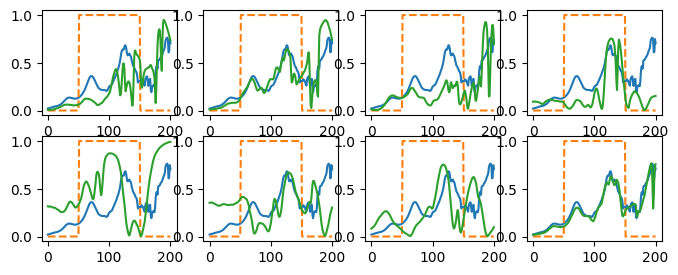

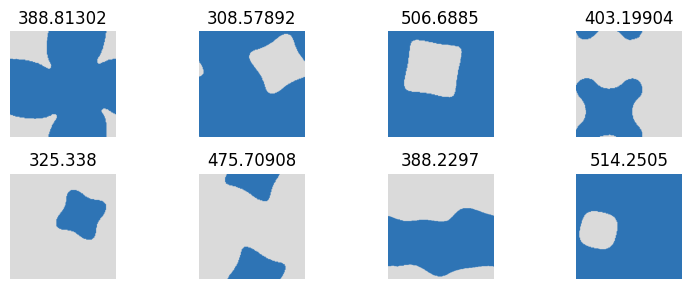

In [3]:
mat = sio.loadmat('./srcs/data_FDTD.mat')
tpower = mat['T_power'].squeeze()
p = mat['period'].squeeze()
shape = mat['pattern'].squeeze()
num_rows = 2
num_cols = 4
label = 0
rand_seed = 444
num_images = num_rows * num_cols


tpower = np.reshape(tpower, (1, -1))
mask = np.zeros_like(tpower)
tpower = tf.cast(tpower, tf.float32)
mask[:, 50:150] = 1.
mask = tf.cast(mask, tf.float32)

tpower_cond = diffusion.t_encoder(tpower, mask)
tpower_cond = tf.tile(tpower_cond, (num_images, 1, 1))
tpower = tpower.numpy()
mask = mask.numpy()

labels = tf.zeros((num_images,), dtype=tf.int64) + label

gen_images = diffusion.generate(num_images, 40, [labels, tpower_cond], seed=rand_seed)
gen_shapes, gen_periods = diffusion.decouple_generated_sample(gen_images)
sio.savemat('./runtime_data/gen_images.mat', {'shapes': gen_shapes, 'periods': gen_periods, 'tcond': tpower, 'mask': mask})
tpower_pred, tphase_pred = diffusion.t_predictor(gen_shapes[..., tf.newaxis], gen_periods[:, tf.newaxis])
tpower_pred = tpower_pred.numpy()

# plt.plot(tpower[0, ::-1])
# plt.plot(mask[0, ::-1], '--')
# plt.show()

plt.figure(figsize=(8, 3))
for n in range(num_images):
    plt.subplot(num_rows, num_cols, n + 1)
    plt.plot(tpower[0, ::-1])
    plt.plot(mask[0, ::-1], '--')
    plt.plot(tpower_pred[n, ::-1])
    # plt.show()
plt.show()

generated_images = (gen_shapes.squeeze() * 255.0).astype(np.uint8)
plt.figure(figsize=(8, 3))

for n in range(num_images):
    plt.subplot(num_rows, num_cols, n + 1)
    plt.imshow(generated_images[n], cmap=cmap)
    plt.axis('off')
    plt.title(gen_periods[n])

plt.tight_layout()
plt.show()